<h1>Basic of ML</h1>
<h2>Theme: songs binar classification (genre)</h2>
<h2>Done by:</h2>
<h2>BDA</h2>
<h2>KBS</h2>

<H1>Введение</H1>
<H2>Актуальность классификации песен по жанрам неоспарима: 62% пользователей во всем мире слушают музыку через сервисы потоковый музыки (стриминг), например Яндекс музыка или Spotify, (по данным GlobalWebIndex за IV квартал 2016 г.)  в дальнейшем наблюдалась тенденция увеличения данного показателя. Люди, слушающие определёные жанры, хотят находить похожие песни по тексту, жанру, эстетике и тому подобное, следовательно, песни нужно классфицировать по данным признакам, из которых наиболее значемые - текст песни и её жанр, откуда жанр является определяющим, поэтому именно его мы и классифицируем.</H2>
<H2>Классификация песен по жанрам — это процесс автоматического (или ручного) распределения музыкальных композиций по стилям (жанрам), таким как поп и рэп. Основной целью данного процесса является упрощение поиска и рекомендации музыки, анализ пользовательских предпочтений.</H2>

<H1>Практическая реализация</H1>

<h2>Импорт библиотек и нужных модулей</h2>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, re, nltk,  matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dibus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dibus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<h2>Загрузка данных и их анализ</h2>

In [3]:
# Загрузка данных
df_train = pd.read_csv("train.csv", sep=',')
df_test = pd.read_csv("test.csv", sep=',')

# Анализ train.csv
display(df_train.tail(5))
display(df_train.describe())
df_train.info()

,lyric,class
51049,"I told her pour me some more, then she went ri...",0
51050,Hit the ground and crawl to the dresser,0
51051,Just keep breathin' and breathin' and breathin...,1
51052,"Down go the system, long live the king (King)",0
51053,If your mother knew all the things we do (From...,1


,class
count,51054.000000
mean,0.434227
std,0.495660
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51054 entries, 0 to 51053
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyric   51054 non-null  object
 1   class   51054 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 797.8+ KB


In [4]:
# Анализ test.csv
display(df_test.tail(5))
display(df_test.describe())
df_test.info()

,id,lyric
2671,2671,"So tell me, how deep is your love?"
2672,2672,If this is all we're living for
2673,2673,"I'll never let up on the pedal, might as well ..."
2674,2674,"Turned my temple down into a prison, s***"
2675,2675,"Yeah that's a fact, but I never been p****"


,id
count,2676.000000
mean,1337.500000
std,772.638984
min,0.000000
25%,668.750000
50%,1337.500000
75%,2006.250000
max,2675.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676 entries, 0 to 2675
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2676 non-null   int64 
 1   lyric   2676 non-null   object
dtypes: int64(1), object(1)
memory usage: 41.9+ KB


<h2>Предобработка данных</h2>

In [5]:
# Обработка данных
target_map = {1: 'pop', 0: 'rap'}
df_train['genre'] = df_train['class'].map(target_map)
df_train['lyric'] = df_train['lyric'].str.replace(',', '')

display(df_train)

,lyric,class,genre
0,Can't drink without thinkin' about you,1,pop
1,Now Lil Pump flyin' private jet (Yuh),0,rap
2,No matter fact you ain't help me when I had no...,0,rap
3,And you could find me I ain't hidin',0,rap
4,From the way you talk to the way you move,1,pop
...,...,...,...
51049,I told her pour me some more then she went rig...,0,rap
51050,Hit the ground and crawl to the dresser,0,rap
51051,Just keep breathin' and breathin' and breathin...,1,pop
51052,Down go the system long live the king (King),0,rap


<h2>Аугментация данных</h2>

In [6]:
# Аугментация данных "шумом" - функция
def augment_text(text, num_augments=5):
    """
    Функция для аугментации с помощью "шумов".
    
    Args:
        text (str): Входной текст.
        num_augments (int): Максимальная длина последовательности.
    
    Returns:
        list: массив предложений с "шумами".
    """
    augmented_texts = []
    words = text.split()
    for _ in range(num_augments):
        # Перемешиваем слова
        permuted = np.random.permutation(words)
        # Добавляем небольшой шум в текст
        noise = ["xxrandom"] * np.random.randint(1, 3)
        augmented = " ".join(list(permuted) + noise)
        augmented_texts.append(augmented)
    return augmented_texts

# Аугментация для класса "pop"
pop_texts = df_train[df_train['class'] == 1]['lyric']
augmented_pop_texts = pop_texts.apply(lambda x: augment_text(x)).explode()
augmented_pop_labels = [1] * len(augmented_pop_texts)

# Объединение с оригинальным набором данных
df_augmented = pd.DataFrame({'lyric': augmented_pop_texts, 'class': augmented_pop_labels})
df_train = pd.concat([df_train, df_augmented], ignore_index=True)

# Аугментация синонимами - функция
def synonym_augmentation(text, num_augments=4):
    """
    Функция для аугментации с помощью синонимов.
    
    Args:
        text (str): Входной текст.
        num_augments (int): Максимальная длина последовательности.
    
    Returns:
        list: массив предложений, созданных из синонимов.
    """
    words = text.split()
    augmented_texts = []
    for _ in range(num_augments):
        new_words = []
        for word in words:
            synonyms = wordnet.synsets(word)
            if synonyms:
                new_word = synonyms[0].lemmas()[0].name()  # Первый синоним
                new_words.append(new_word)
            else:
                new_words.append(word)
        augmented_texts.append(" ".join(new_words))
    return augmented_texts

#аугментация для "rap"
rap_texts = df_train[df_train['class'] == 0]['lyric']
augmented_rap_texts = rap_texts.apply(lambda x: synonym_augmentation(x)).explode()
augmented_rap_labels = [0] * len(augmented_rap_texts)

# Объединение с оригинальным набором данных
df_augmented_rap = pd.DataFrame({'lyric': augmented_rap_texts, 'class': augmented_rap_labels})
df_train = pd.concat([df_train, df_augmented_rap], ignore_index=True)

# Подготовка текста и меток
train_text = df_train['lyric']
train_label = df_train['class']


<h2>Токенизация</h2>

In [7]:
# параметры текста
num_words = 10000
max_len = 100

# токенизация
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_text)

x_seq = tokenizer.texts_to_sequences(train_text)
x_pad = pad_sequences(x_seq, maxlen=max_len)

y = np.array(train_label)

<h2>Разделение данных на выборки</h2>

In [8]:
# Разделение на train (80%), val (10%) и test (10%)
x_train, x_temp, y_train, y_temp = train_test_split(x_pad, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Данные для тренировки: {x_train.shape}, Данные для валидации: {x_val.shape}, Данные для тестировки: {x_test.shape}")

Данные для тренировки: (221951, 100), Данные для валидации: (27744, 100), Данные для тестировки: (27744, 100)


<h2>Смотрим весы классов</h2>

In [9]:
# Балансировка классов
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: 0.9605690247639161, 1: 1.042806803232475}


<h2>Последовательная модель с:
<ul>
    <li>Эмбендингом (преобразование индексов в векторы): вход (количество векторов) - 10000, выход (размерность векторного представления) - 100, входная длина (последовательности)- 100</li>
    <li>Регуляризация - dropout в 20% (ограничения для предотвращения переобучения)</li>
    <li>LSTM (Long-Short Term Memory) - слой есть рекуррентный слой для обработки последовательных данных с 32 нейронами</li>
    <li>Dense - полносвязный слой с ReLU-активацией и 256-ю нейронами</li>
    <li>Регуляризация в 20%</li>
    <li>Выходной dense с активацией для бинарной классификации с 1 нейроном</li>
</ul>
</h2>

In [10]:
# Создание модели
model = Sequential([
    Embedding(input_dim=num_words, output_dim=100, input_length=max_len),
    Dropout(0.2),
    LSTM(32),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])


C:\Users\dibus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

<h2>Обучение модели</h2>

In [12]:
# Обучение модели
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=100,
    epochs=4,
    class_weight=class_weights_dict
)

Epoch 1/4
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 56s 24ms/step - AUC: 0.9853 - accuracy: 0.9426 - loss: 0.1471 - val_AUC: 0.9953 - val_accuracy: 0.9631 - val_loss: 0.0866
Epoch 2/4
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - AUC: 0.9963 - accuracy: 0.9677 - loss: 0.0756 - val_AUC: 0.9959 - val_accuracy: 0.9654 - val_loss: 0.0818
Epoch 3/4
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 53s 24ms/step - AUC: 0.9976 - accuracy: 0.9736 - loss: 0.0617 - val_AUC: 0.9958 - val_accuracy: 0.9681 - val_loss: 0.0774
Epoch 4/4
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 54s 24ms/step - AUC: 0.9984 - accuracy: 0.9787 - loss: 0.0501 - val_AUC: 0.9949 - val_accuracy: 0.9691 - val_loss: 0.0818


<h2>Анализ модели</h2>

In [13]:
# Оценка модели на тестовой выборке
y_pred = (model.predict(x_test) > 0.5).astype("int32")

results = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]:.4f}, Test AUC: {results[2]:.4f}")

# Отчёт классификации
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['rap', 'pop']))


867/867 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Test Loss: 0.0869, Test Accuracy: 0.9687, Test AUC: 0.9945
Classification Report:
              precision    recall  f1-score   support

         rap       0.97      0.97      0.97     14401
         pop       0.97      0.97      0.97     13343

    accuracy                           0.97     27744
   macro avg       0.97      0.97      0.97     27744
weighted avg       0.97      0.97      0.97     27744



<h2>Графики обучения (точности и потерь)</h2>

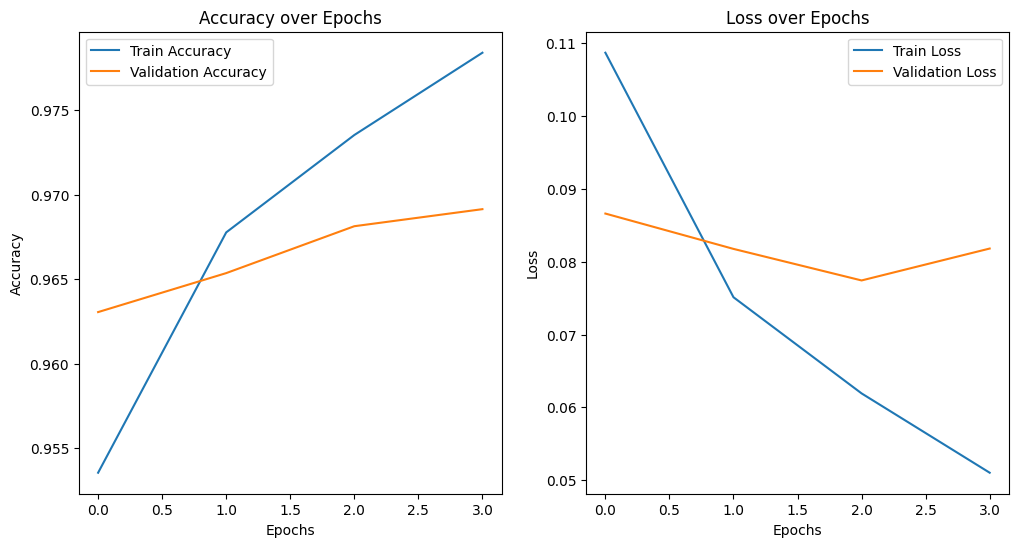

In [14]:
# Построение графиков обучения
plt.figure(figsize=(12, 6))

# Точность
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Ошибка
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<h2>Матрица ошибок</h2>

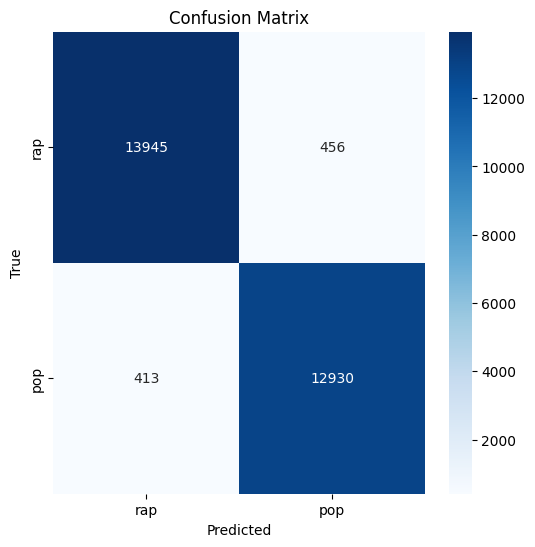

In [15]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['rap', 'pop'], yticklabels=['rap', 'pop'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<h2>Предсказания на тестовой выборке с сохранением результатов</h2>

In [16]:
# Предсказание на test.csv (без меток)
df_test['lyric'] = df_test['lyric'].str.replace(',', '')
x_test_final = tokenizer.texts_to_sequences(df_test['lyric'])
x_test_final = pad_sequences(x_test_final, maxlen=max_len)

y_pred_test = (model.predict(x_test_final) > 0.5).astype("int32")
df_test['predicted_class'] = y_pred_test
df_test['predicted_genre'] = df_test['predicted_class'].map(target_map)

# Сохранение предсказаний
df_test.to_csv("test_with_predictions.csv", index=False)
print("Предсказания на test.csv сохранены в test_with_predictions.csv")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Предсказания на test.csv сохранены в test_with_predictions.csv


In [17]:
# Смотрим файл предсказаний
df_test_with_predictions = pd.read_csv('test_with_predictions.csv', sep = ',')
display(df_test_with_predictions)

,id,lyric,predicted_class,predicted_genre
0,0,Now they know my name wherever I go,1,pop
1,1,If your girl don't get it poppin' put me on yo...,1,pop
2,2,P1 cleaner than your church shoes ah,1,pop
3,3,Bodies start to drop ayy (Hit the floor),0,rap
4,4,I don't look to the sky no mo',0,rap
...,...,...,...,...
2671,2671,So tell me how deep is your love?,1,pop
2672,2672,If this is all we're living for,1,pop
2673,2673,I'll never let up on the pedal might as well g...,0,rap
2674,2674,Turned my temple down into a prison s***,0,rap


In [18]:
# Сохранение модели для экспорта
model.save("model.keras")

<H1>Заключение</H1>

<h2>
Выводы <br>
В ходе проектной деятельности мы создали LSTM - разновидность реккурентной нейронной сети (RNN) - которую смогли обучить бинарной классификации текстов песен с жанрами рэп и поп с хорошой точностью <br>
Статистика обучения:
<ul>
    <li>Epoch 1/4 - AUC: 0.9853 - accuracy: 0.9433 - loss: 0.1472 - val_AUC: 0.9954 - val_accuracy: 0.9645 - val_loss: 0.0847</li>
    <li>Epoch 2/4 - AUC: 0.9964 - accuracy: 0.9680 - loss: 0.0754 - val_AUC: 0.9957 - val_accuracy: 0.9659 - val_loss: 0.0799</li>
    <li>Epoch 3/4 - AUC: 0.9976 - accuracy: 0.9741 - loss: 0.0605 - val_AUC: 0.9955 - val_accuracy: 0.9686 - val_loss: 0.0790</li>
    <li>Epoch 4/4 - AUC: 0.9984 - accuracy: 0.9788 - loss: 0.0501 - val_AUC: 0.9952 - val_accuracy: 0.9708 - val_loss: 0.0794</li>
</ul>
Точность модели - 0.9688 <br>
Работа модели (с пользовательским вводом текстов песен соответствующих жанров):
</h2>

In [19]:
def predict_genre(text, model, tokenizer, max_len):
    """
    Функция для предсказания жанра текста.
    
    Args:
        text (str): Входной текст.
        model (keras.Model): Обученная модель.
        tokenizer (Tokenizer): Токенизатор, использованный при обучении.
        max_len (int): Максимальная длина последовательности.
    
    Returns:
        str: Предсказанный жанр ("rap" или "pop").
    """
    # Предобработка текста
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)
    
    # Предсказание
    prediction = model.predict(text_pad)
    genre = "pop" if prediction[0][0] > 0.5 else "rap"
    
    return genre

# Пример использования
while True:
    input_text = input("Введите текст песни для предсказания (или 'ex' для выхода): ")
    if input_text.lower() == "ex":
        print("Завершение работы.")
        break
    predicted_genre = predict_genre(input_text, model, tokenizer, max_len)
    print(f"Предсказанный жанр: {predicted_genre}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Предсказанный жанр: rap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Предсказанный жанр: rap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Предсказанный жанр: rap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Предсказанный жанр: rap
Завершение работы.


<h1>Список источников</h1>
<h2>
<ol>
    <li>https://www.kaggle.com/datasets/sshikamaru/music-genre-classification/data - Ссылка на датасет</li>
    <li>https://nerdit.ru/deep-learning-for-nlp-anns-rnns-and-lstm-explained/ - Теория по качественной работе с NLP на ANN, RNN, LSTM</li>
    <li>https://aws.amazon.com/ru/what-is/recurrent-neural-network/ - Теория по RNN/LSTM</li>
    <li>https://dzen.ru/a/X99iLvWm9Cn8nL9f - RNN, LSTM - практическая реализация</li>
</ol>
</h2>